# KauriID -- A User Journey

In [1]:
import env3.bin.activate_this
import datetime
import nacl.utils, base58

In [2]:
import prov.model
import prov.dot

In [3]:
from IPython.display import SVG, display, Image
def show_svg(content):
    display(SVG(content))

In [4]:
NAMESPACES = {
    'kauriid': 'http://kauriid.nz',  # KauriID system (present by default)
    'dct': 'http://purl.org/dc/terms/',  # Dublin Core Terms (present by default)
    'aa': 'http://www.aa.co.nz/',  # AA
    'asb': 'http://www.asb.co.nz/',  # ASB
    'nzta': 'http://www.nzta.govt.nz/',  # NZ Transport Authority
    'watercare': 'http://www.watercare.co.nz',  # NZ Watercare
    'harcourts': 'http://www.harcourts.co.nz',  # Harcourts real estate agent
    'dia': 'http://www.dia.govt.nz/',  # NZ Department of Internal Affairs
    'nzpost': 'http://www.nzpost.co.nz',  # NZ Post
}
def add_namespaces(a_prov_document, namespaces: list):
    a_prov_document.add_namespace('kauriid', 'http://kauriid.nz')  # KauriID system
    a_prov_document.add_namespace('dct', 'http://purl.org/dc/terms/')  # Dublin Core Terms
    for item in namespaces:
        namespace_uri = NAMESPACES[item]
        a_prov_document.add_namespace(item, namespace_uri)

## Step 0: Some Preliminaries

First, we need some 'things' that we can refer to down the line.

These are:
* Entities for evidence validation plans as sub-tasks to the attestation process:
    - Manual validation
    - Automatic validation
* Utility functions making the further things cleaner

### Validation entities

In [5]:
preliminaries = prov.model.ProvDocument()
add_namespaces(preliminaries, [])

In [6]:
GENERIC_VERIFICATION = 'kauriid:procedures/evidence_checks/ipns/QmNXXXgenericXXX...51Q'
generic_verification_plan = preliminaries.entity(GENERIC_VERIFICATION,
                                               other_attributes={'prov:type': 'prov:Plan'})

GENERIC_MANUAL_VERIFICATION = 'kauriid:procedures/evidence_checks/ipns/QmXXXXgenericmanualXXX...uco'
OLD_MANUAL_VERIFICATION = 'kauriid:procedures/evidence_checks/ipns/QmQXXXoldmanualXXX...ETw'
CURRENT_MANUAL_VERIFICATION = 'kauriid:procedures/evidence_checks/ipns/QmdXXXcurrentmanualXXX...YgV'
generic_manual_verification_plan = preliminaries.entity(GENERIC_MANUAL_VERIFICATION,
                                                      other_attributes={'prov:type': 'prov:Plan'})
old_manual_verification_plan = preliminaries.entity(OLD_MANUAL_VERIFICATION,
                                                  other_attributes={'prov:type': 'prov:Plan'})
current_manual_verification_plan = preliminaries.entity(CURRENT_MANUAL_VERIFICATION,
                                                      other_attributes={'prov:type': 'prov:Plan'})

generic_manual_verification_plan.specializationOf(generic_verification_plan)
old_manual_verification_plan.specializationOf(generic_manual_verification_plan)
current_manual_verification_plan.specializationOf(generic_manual_verification_plan)
old_manual_verification_plan.wasInvalidatedBy(current_manual_verification_plan)
current_manual_verification_plan.wasDerivedFrom(old_manual_verification_plan)

GENERIC_AUTO_VERIFICATION = 'kauriid:procedures/evidence_checks/ipns/QmUXXXautogenericXXX...1Xg'
OLD_AUTO_VERIFICATION = 'kauriid:procedures/evidence_checks/ipns/QmWXXXautooldXXX...FtL'
CURRENT_AUTO_VERIFICATION = 'kauriid:procedures/evidence_checks/ipns/QmcXXXautocurrentXXX...3GN'
generic_auto_verification_plan = preliminaries.entity(GENERIC_AUTO_VERIFICATION,
                                                    other_attributes={'prov:type': 'prov:Plan'})
old_auto_verification_plan = preliminaries.entity(OLD_AUTO_VERIFICATION,
                                                other_attributes={'prov:type': 'prov:Plan'})
current_auto_verification_plan = preliminaries.entity(CURRENT_AUTO_VERIFICATION,
                                                    other_attributes={'prov:type': 'prov:Plan'})

generic_auto_verification_plan.specializationOf(generic_verification_plan)
old_auto_verification_plan.specializationOf(generic_auto_verification_plan)
current_auto_verification_plan.specializationOf(generic_auto_verification_plan)
old_auto_verification_plan.wasInvalidatedBy(current_auto_verification_plan)
current_auto_verification_plan.wasDerivedFrom(old_auto_verification_plan)

<ProvEntity: kauriid:procedures/evidence_checks/ipns/QmcXXXautocurrentXXX...3GN>

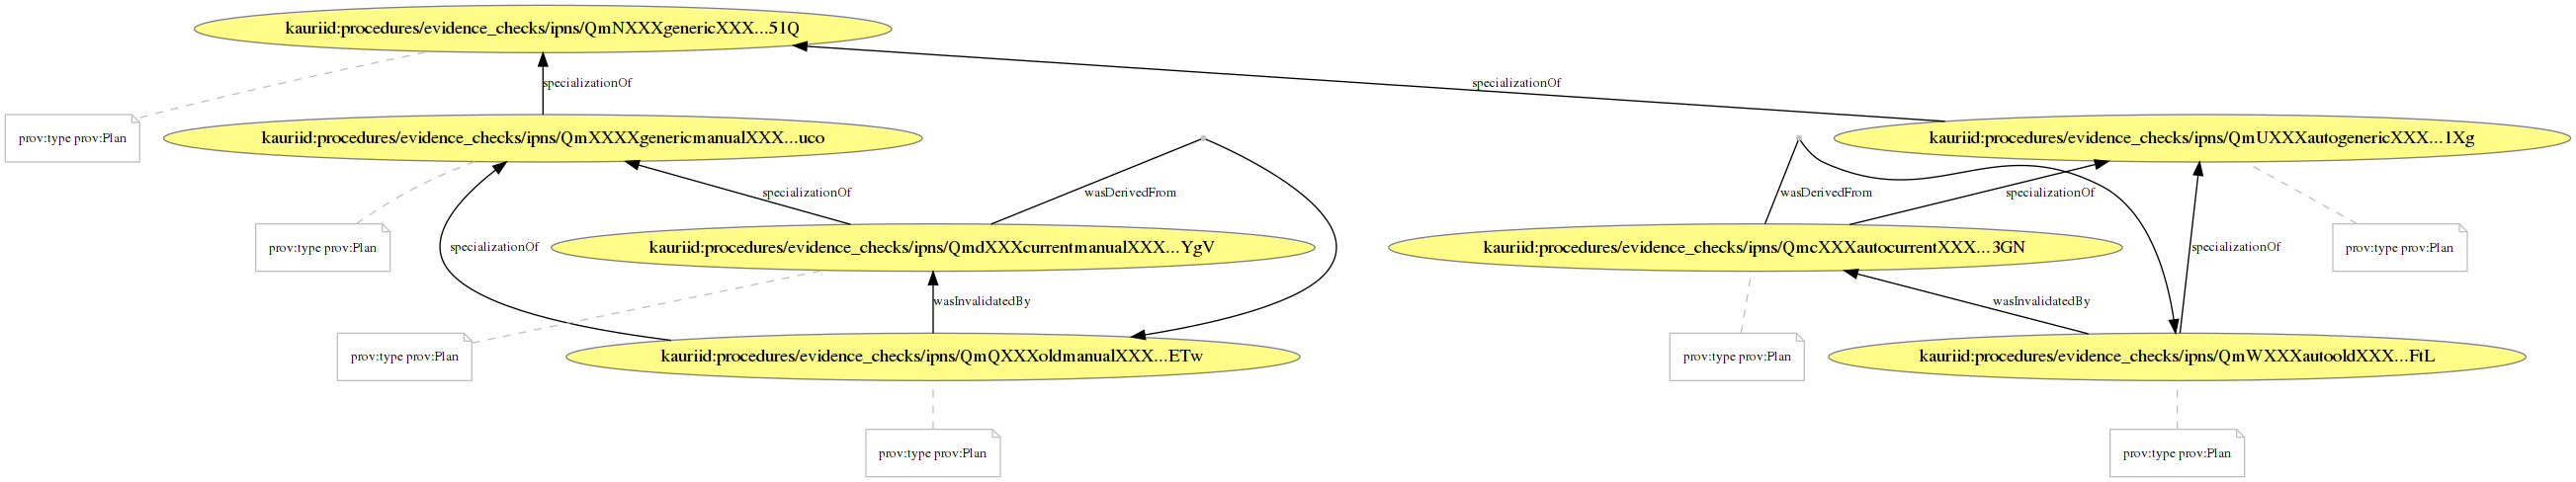

In [7]:
# Rendering the preliminaries in a visual graph.
dot_preliminaries = prov.dot.prov_to_dot(preliminaries)
#show_svg(dot_preliminaries.create_svg())
Image(dot_preliminaries.create_png())

### A function to draft up the attestation provenance graph

In [8]:
def _make_address(length, magic, gem=None):
    value = nacl.utils.random(length)
    address = base58.b58encode(magic + value)
    if gem:
        if isinstance(gem, str):
            gem = gem.encode('utf-8')
        address = address[:3] + b'XXX' + gem + b'XXX...' + address[-3:]
    return address.decode('utf-8')
def _make_eth(gem=None):
    return _make_address(24, b'\x01\x04', gem)
def _make_ipfs(gem=None):
    return _make_address(32, b'\x12 ', gem)
class SimpleUTC(datetime.tzinfo):
    def tzname(self, **kwargs):
        return 'UTC'
    def utcoffset(self, dt):
        return datetime.timedelta(0)
def _make_current_utc_datetime():
    now = datetime.datetime.utcnow()
    return now.replace(tzinfo=SimpleUTC())

In [9]:
def _delegation_exists(prov_document, delegate, responsible):
    # Split off namespaces.
    delegate = delegate.split(':')[1]
    responsible = responsible.split(':')[1]
    # Find delegation records.
    delegations = [item.attributes
                   for item in prov_document.records
                   if type(item) is prov.model.ProvDelegation]
    for delegation in delegations:
        party1, party2 = delegation
        if party1[0].localpart == 'delegate':
            recorded_delegate = party1[1].localpart
            recorded_responsible = party2[1].localpart
        else:
            recorded_delegate = party2[1].localpart
            recorded_responsible = party1[1].localpart
        if recorded_delegate == delegate and recorded_responsible == responsible:
            return True

In [10]:
def add_attestation(prov_document,
                    ancestors: list,
                    evidence_elements: list,
                    attester,
                    delegation_chain: list,  # Highest level down to direct delegator of attester.
                    verification_procedure,
                    *,
                    target_label=None,
                    content=()):
    """
    :return: Target entity object.
    """
    # Make target entity.
    target_id = _make_ipfs(target_label)
    target_name = 'kauriid:attestations/ipns/{}'.format(target_id)
    other_attributes = {'prov:content': content} if content else {}
    target = prov_document.entity(target_name, other_attributes=other_attributes)
    # Make activities.
    attestation = prov_document.activity('kauriid:identityAttestation/{}'.format(target_id),
                                         other_attributes={'dct:hasPart': 'kauriid:evidenceVerification'})
    evidence_verification = prov_document.activity('kauriid:evidenceVerification/{}'.format(target_id))
    # Tie things together.
    previous_delegator = delegation_chain[0]
    for actor_id in delegation_chain[1:] + [attester]:
        if not _delegation_exists(prov_document, actor_id, previous_delegator):
            prov_document.actedOnBehalfOf(actor_id, previous_delegator)
        previous_delegator = actor_id
    attestation.wasInformedBy(evidence_verification)
    attestation.wasAssociatedWith(attester, attributes={'prov:hadRole': 'kauriid:attester'})
    evidence_verification.wasAssociatedWith(attester, attributes={'prov:hadRole': 'kauriid:verifier'})
    evidence_verification.used(verification_procedure)  # TODO: What was it about the prov:hadPlan annotation?
    target.wasGeneratedBy(attestation, attributes={'prov:generatedAtTime': _make_current_utc_datetime()})
    for entity_id in evidence_elements + ancestors:
        attestation.used(entity_id)
        target.wasDerivedFrom(entity_id)
    return target.identifier
    

## Step 1: Onboarding for AA Membership

The user shows up in an AA centre with the driver licence and a Watercare bill for proof of address. The AA representative offers him to at the same time help create a KauriID identity.

The user downloads the KauriID app and creates a new (empty) KauriID. The AA representative then helps to populate it with the identity attributes required for a new AA membership. AA will go about verifying the details as the usually do (using physical artifacts), and make an attestation of a number of extracted details from these on the user's new KauriID.

In [11]:
# Create a new provenance document for the new identity.
onboarding = prov.model.ProvDocument()
add_namespaces(onboarding, ['aa', 'nzta', 'watercare'])
# Make the attester.
BOB = 'aa:staff/{}'.format(_make_eth('bob'))
# Make the PROV graph.
initial = add_attestation(onboarding,
                          ancestors=[],
                          evidence_elements=['nzta:dl/DJ034005-v193', 'watercare:customers/4711/invoices/201809.pdf'],
                          attester=BOB,
                          delegation_chain=['aa:Organisation'],
                          verification_procedure=CURRENT_MANUAL_VERIFICATION,
                          target_label='attestation01')
                          # content=('name', 'dob', 'photo', 'dl_no', 'dl_version', 'dl_issued_ts', 'dl_expires_ts',
                          #          'street', 'suburb', 'city', 'post_code'))

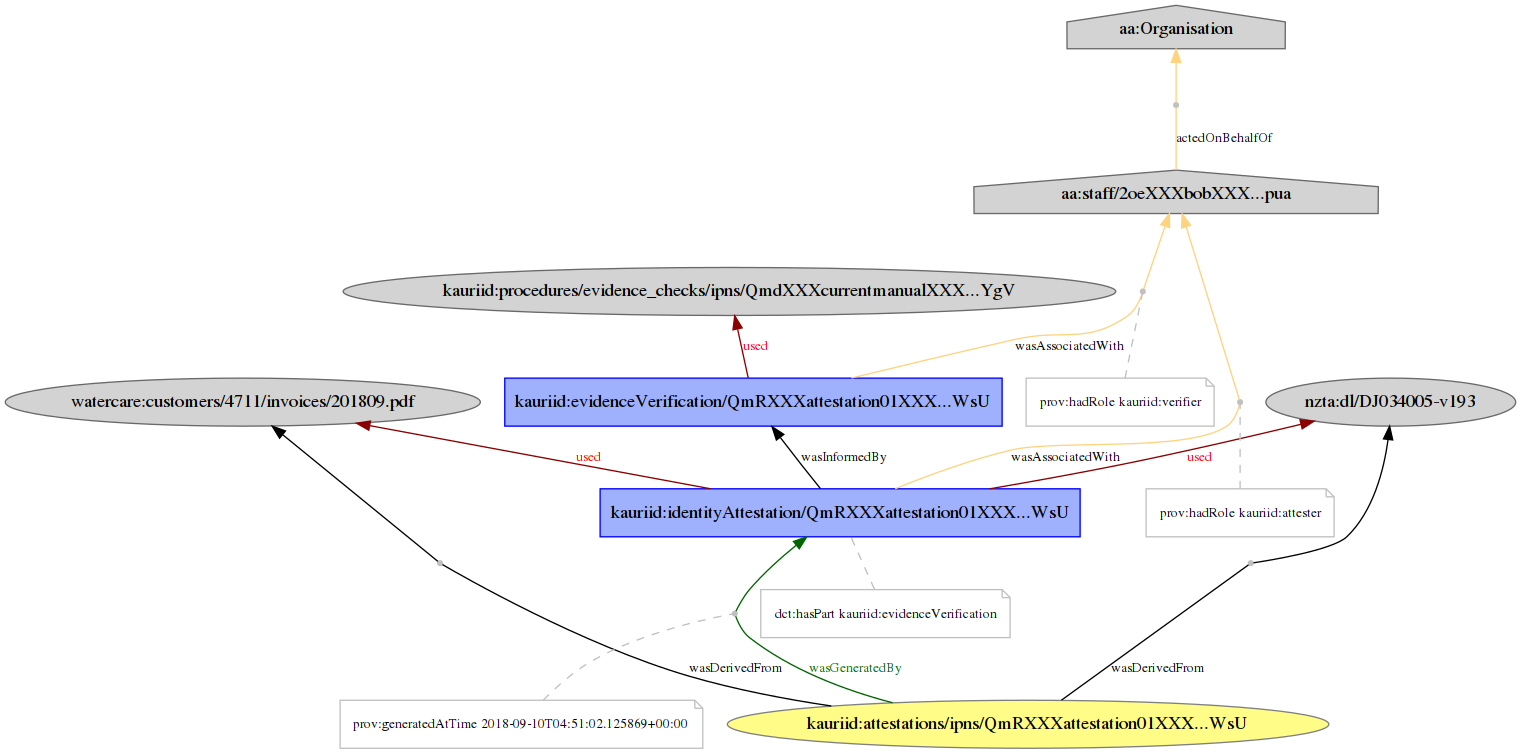

In [12]:
# Rendering the attestation in a visual graph.
dot_aa = prov.dot.prov_to_dot(onboarding)
#show_svg(dot_aa.create_svg())
Image(dot_aa.create_png())

In [13]:
# Visualise the attestation in an image file.
dot_aa.write_png('kauriid-prov-aa.png')
dot_aa.write_pdf('kauriid-prov-aa.pdf')
dot_aa.write_svg('kauriid-prov-aa.svg')

In [14]:
# Serialisation of the attestation trace in PROV-N format.
# Note: Other formats are available.
print(onboarding.get_provn())

document
  prefix kauriid <http://kauriid.nz>
  prefix dct <http://purl.org/dc/terms/>
  prefix aa <http://www.aa.co.nz/>
  prefix nzta <http://www.nzta.govt.nz/>
  prefix watercare <http://www.watercare.co.nz>
  
  entity(kauriid:attestations/ipns/QmRXXXattestation01XXX...WsU)
  activity(kauriid:identityAttestation/QmRXXXattestation01XXX...WsU, -, -, [dct:hasPart="kauriid:evidenceVerification"])
  activity(kauriid:evidenceVerification/QmRXXXattestation01XXX...WsU, -, -)
  actedOnBehalfOf(aa:staff/2oeXXXbobXXX...pua, aa:Organisation, -)
  wasInformedBy(kauriid:identityAttestation/QmRXXXattestation01XXX...WsU, kauriid:evidenceVerification/QmRXXXattestation01XXX...WsU)
  wasAssociatedWith(kauriid:identityAttestation/QmRXXXattestation01XXX...WsU, aa:staff/2oeXXXbobXXX...pua, -, [prov:hadRole="kauriid:attester"])
  wasAssociatedWith(kauriid:evidenceVerification/QmRXXXattestation01XXX...WsU, aa:staff/2oeXXXbobXXX...pua, -, [prov:hadRole="kauriid:verifier"])
  used(kauriid:evidenceVerificati

## Step 2: Local Library Membership

The "basket" containing some key identity attributes (attested) is accessed by the library. The attributes contain:

- `name`
- `dob`
- `street`
- `suburb`
- `city`
- `post_code`

## Step 3: Purchase Alcohol

The identity attributes (attested) accessed by the shop are limited to:

- `dob`
- `photo`

## Step 4: Onboarding for a Loan at ASB

The user enters an ASB branch to apply for a loan on their new house. As the KauriID attestations are not "strong enough", further identity validation is required. For this, the user brought in a passport and the sales and purchase agreement for the property.

### Update of Identity Attestations

With this, ASB is able to make a stronger identity attribute attestation, including their "proof of address" attribute basket.

In [15]:
# Create a new provenance document for the new loan application at ASB.
loan_attestation = prov.model.ProvDocument()
add_namespaces(loan_attestation, ['asb', 'dia', 'harcourts'])
# Make the attester.
RAY = 'asb:staff/{}'.format(_make_eth('ray'))
# Make the PROV graph.
stronger = add_attestation(loan_attestation,
                           ancestors=[initial],
                           evidence_elements=['dia:passports/john_doe_0815'],
                           attester=RAY,
                           delegation_chain=['asb:Organisation'],
                           verification_procedure=CURRENT_MANUAL_VERIFICATION,
                           target_label='attestation02')
                           # content=('name', 'dob', 'photo', 'dl_no', 'dl_version', 'dl_issued_ts', 'dl_expires_ts',
                           #          'street', 'suburb', 'city', 'post_code', 'place_of_birth', 'country',
                           #          'passport_type', 'passport_no', 'passport_issued_ts', 'passport_expires_ts'))

### Update to the New Address

Now update to the new residence address from the sales and purchase agreement

In [16]:
new_address = add_attestation(loan_attestation,
                              ancestors=[stronger],
                              evidence_elements=['harcourts:snp/house_47110666.pdf'],
                              attester=RAY,
                              delegation_chain=['asb:Organisation'],
                              verification_procedure=CURRENT_MANUAL_VERIFICATION,
                              target_label='attestation03')
                              # content=('name', 'dob', 'photo', 'dl_no', 'dl_version', 'dl_issued_ts', 'dl_expires_ts',
                              #          'street', 'suburb', 'city', 'post_code', 'place_of_birth', 'country',
                              #          'passport_type', 'passport_no', 'passport_issued_ts', 'passport_expires_ts'))

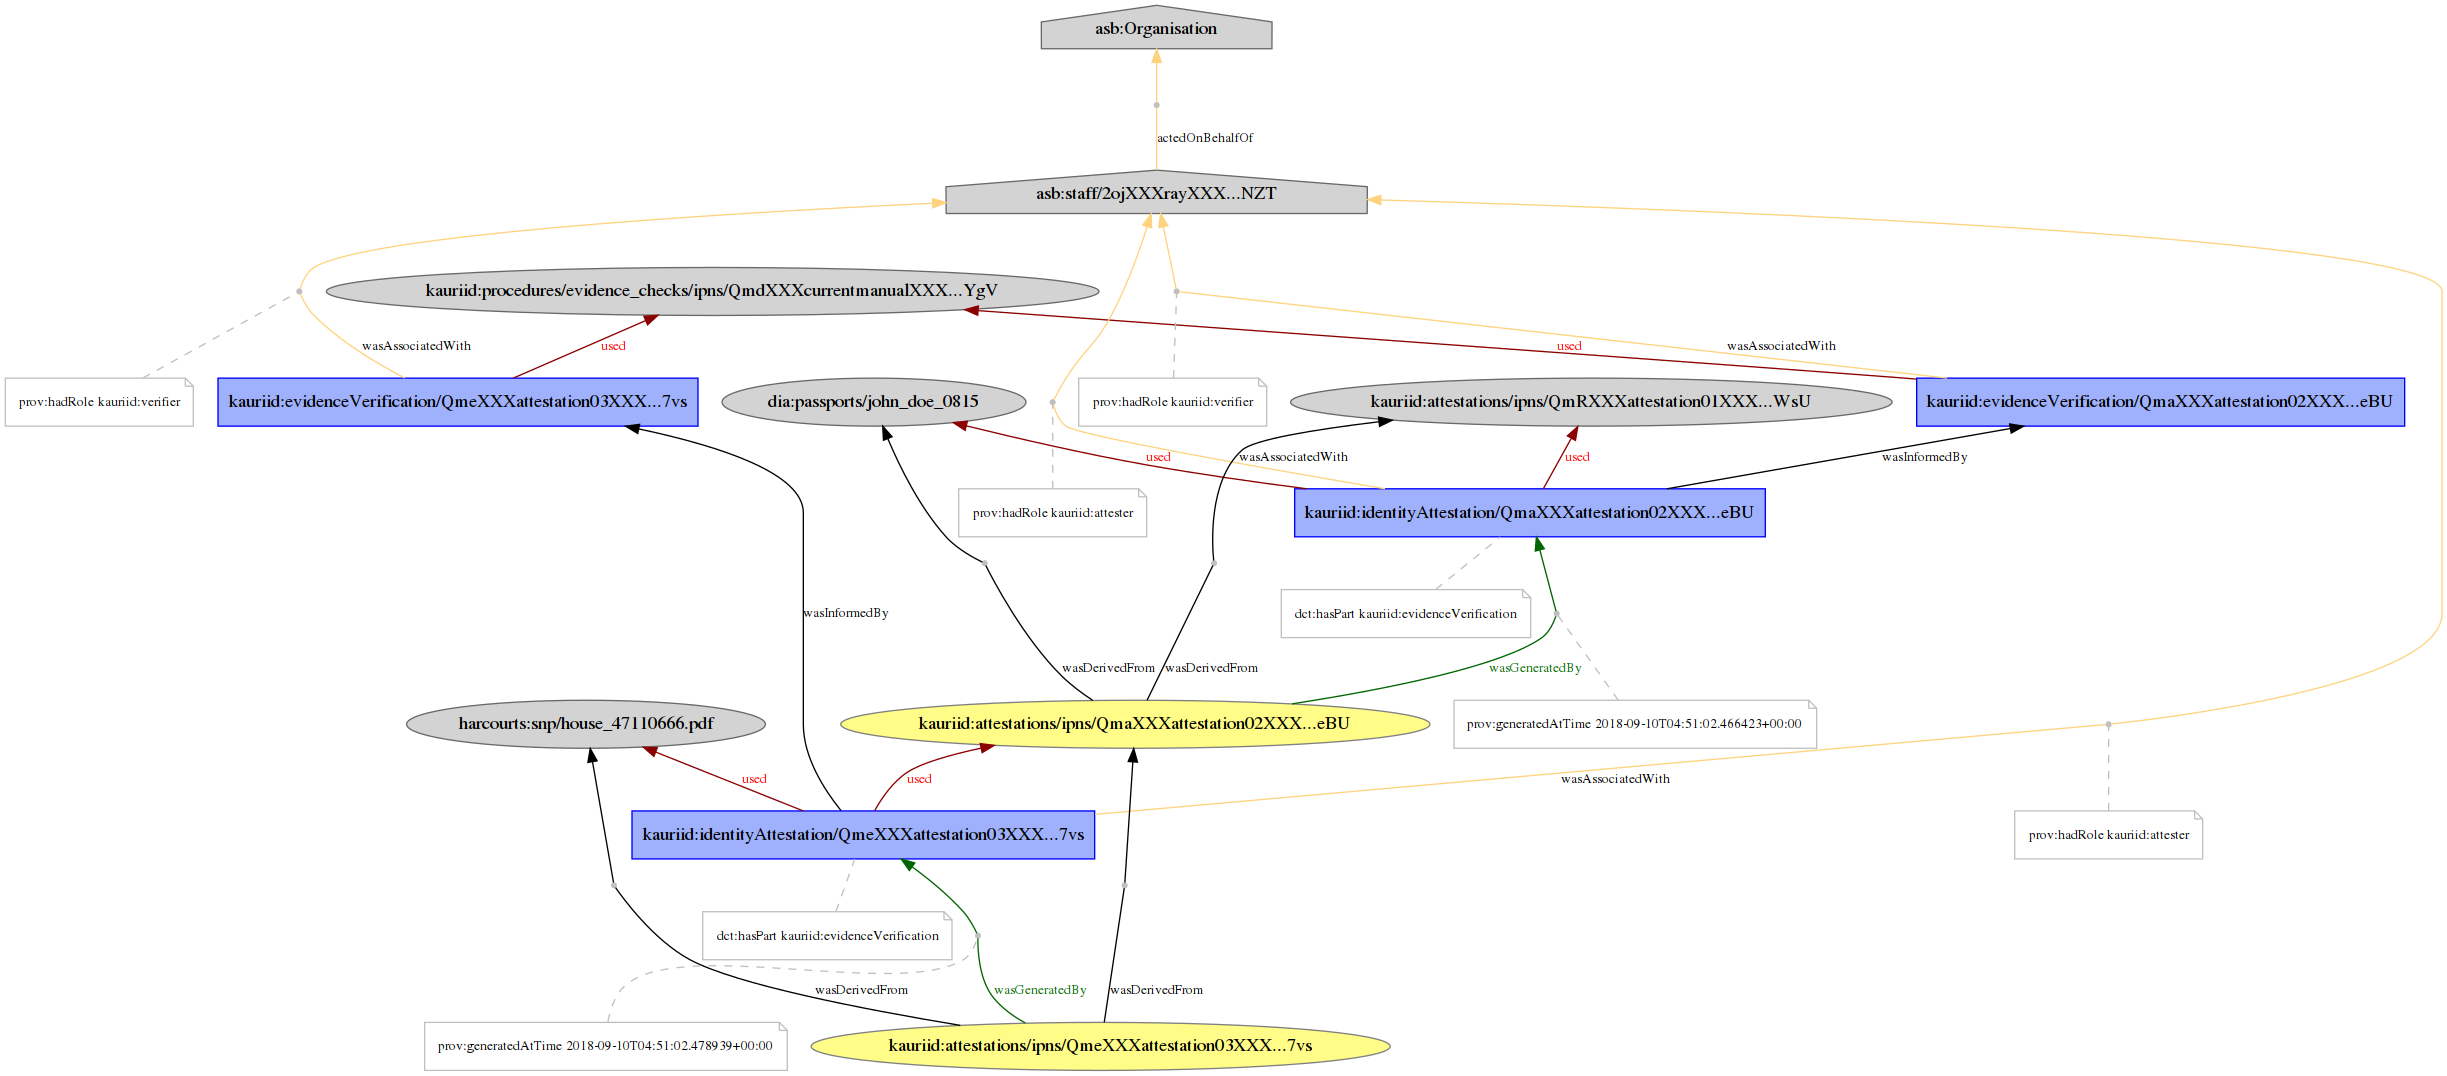

In [17]:
# Rendering the attestation in a visual graph.
dot_asb = prov.dot.prov_to_dot(loan_attestation)
#show_svg(dot_asb.create_svg())
Image(dot_asb.create_png())

In [18]:
# Visualise the attestation in an image file.
dot_asb.write_png('kauriid-prov-asb.png')
dot_asb.write_pdf('kauriid-prov-asb.pdf')
dot_asb.write_svg('kauriid-prov-asb.svg')

### Notification of updated "Address Basket"

The user's KauriID app knows who has received what kind of identity attributes (and baskets). This it can prompt for a list of the attestation recipients, and the user may opt to select those who shall receive a notification for an attribute update. Thus it is entirely in the user's hand (the *self-sovereignty*) of who will receive this update.

It is unlikely that the liquor shop should be notified. However, it may make sense to inform the following:

- AA: Membership is likely to be retained.
- Local Library: Unless the move was to a more remote location, the local library may also benefit from the
  ease of an address update.

## Step 5: Registering to Vote

The user wantes to register to vote. For this the **industry-based** identity attestations are not sufficient. Thus, a visit to the local NZ Post branch is required to acquire a RealMe attestation on the KauriID identity accepted by DIA.

In [19]:
# Create a new provenance document for the new loan application at ASB.
voting_rego = prov.model.ProvDocument()
add_namespaces(voting_rego, ['nzpost', 'dia'])
# Make the attester.
PAT = 'nzpost:staff/{}'.format(_make_eth('pat'))
# Make the PROV graph.
govt_level = add_attestation(voting_rego,
                             ancestors=[new_address],
                             evidence_elements=[],
                             attester=PAT,
                             delegation_chain=['dia:Organisation', 'dia:RealMe', 'nzpost:Organisation'],
                             verification_procedure=CURRENT_AUTO_VERIFICATION,
                             target_label='attestation04')

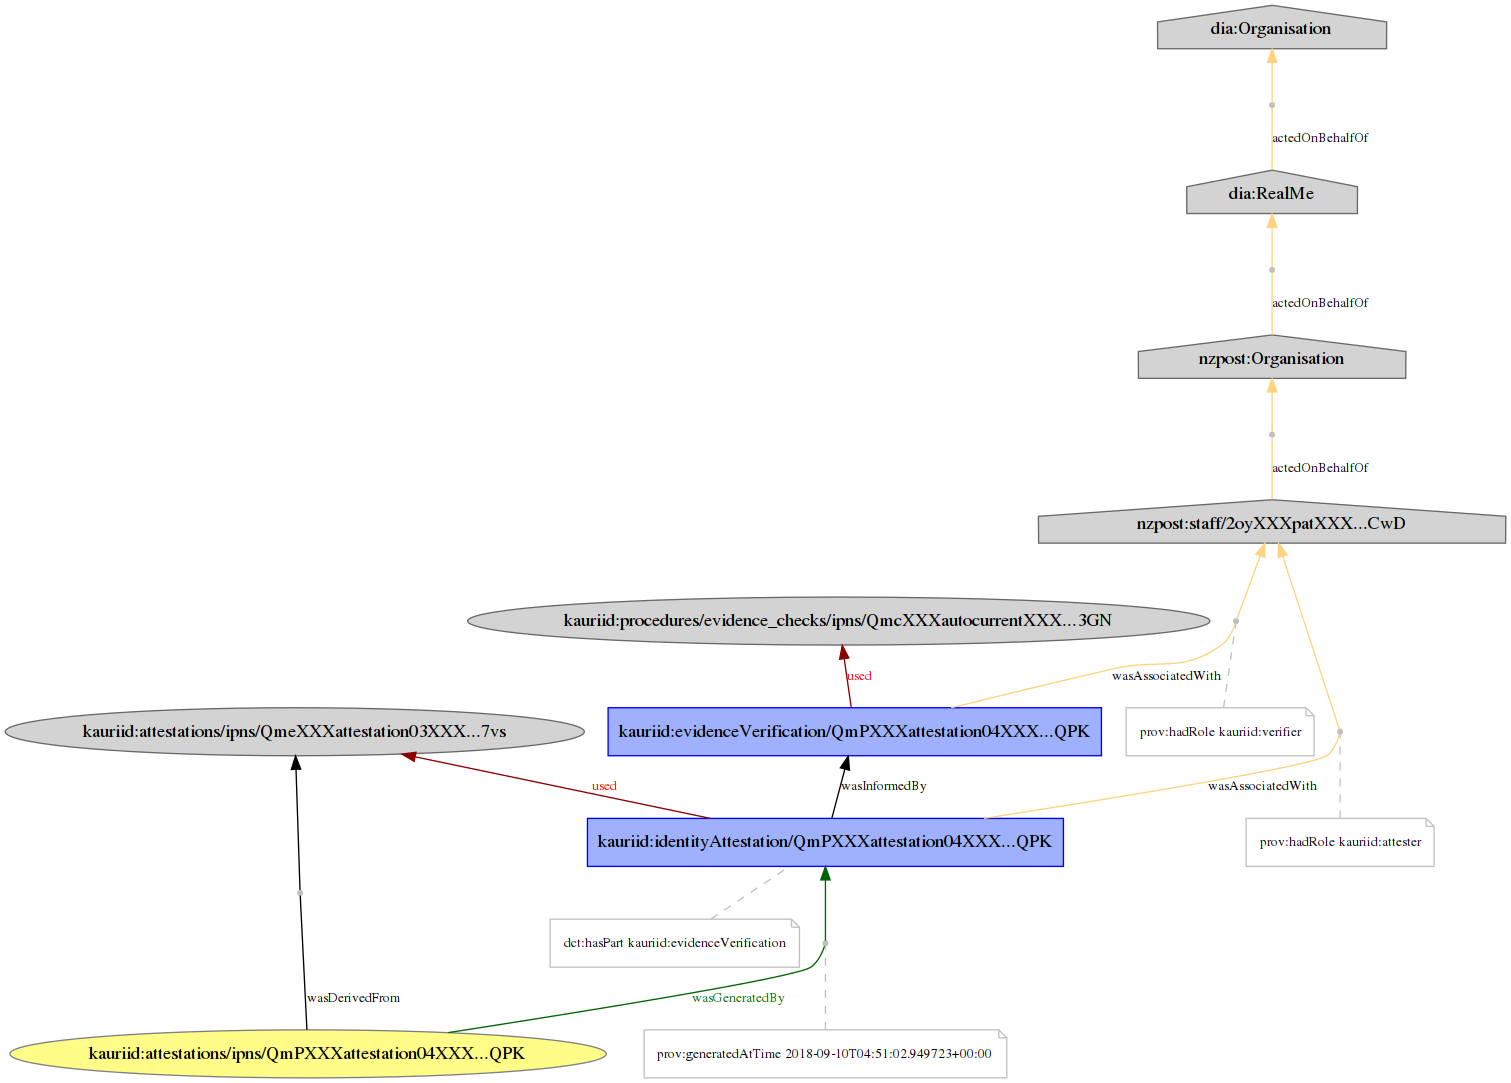

In [20]:
# Rendering the attestation in a visual graph.
dot_realme = prov.dot.prov_to_dot(voting_rego)
#show_svg(dot_realme.create_svg())
Image(dot_realme.create_png())

In [21]:
# Visualise the attestation in an image file.
dot_realme.write_png('kauriid-prov-realme.png')
dot_realme.write_pdf('kauriid-prov-realme.pdf')
dot_realme.write_svg('kauriid-prov-realme.svg')